In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pickle

In [9]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

def substract_pedestals(array_2d):
    subtracted = []
    pedestals = []
    for row in array_2d:
        pedestal = np.argmax(np.bincount(row))
        subtracted.append(row - pedestal)
        pedestals.append(pedestal)
    return np.array(subtracted), np.array(pedestals)


def find_peaks_2d(array_2d, **kwargs):
    props_list = []
    peak_indices = []
    peak_heights = []
    flat_peak_indices = []
    peak_slices = []

    for row_idx, row in enumerate(array_2d):
        peaks, props = find_peaks(row, **kwargs)
        heights = props.get("peak_heights", row[peaks])

        # Get slices using left_ips and right_ips (only if width is calculated)
        slices = []
        left_ips = props.get("left_ips")
        right_ips = props.get("right_ips")
        if left_ips is not None and right_ips is not None:
            for l, r in zip(left_ips, right_ips):
                # Convert fractional indices to integers (rounding)
                start = max(0, int(np.floor(l)))
                end = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [row[p] for p in peaks]  # fallback: just the peak point

        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        flat_peak_indices.extend([(row_idx, col) for col in peaks])
        peak_slices.append(slices)


    return {
        "row_peak_indices": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "waveforms": peak_slices,
        "flat_peak_indices": flat_peak_indices
    }

def save_file(intput_file, output_file, wlen, prominence=200, cut=None):
        data = np.load(intput_file, allow_pickle=True).astype(np.int16)
        data = np.apply_along_axis(substract_peds, axis=1, arr=data)
        if cut is not None:
             data = data[:, cut[0]:cut[1]]
        print(intput_file, data.shape)
        results_dict = find_peaks_2d(data, height=None, distance=100, 
                                           prominence=prominence, rel_height=0.9, wlen=wlen,  
                                           plateau_size=0, width=0 )
        print('saving disabled')
        return results_dict
        # with open(output_file, 'wb') as file:
        #     pickle.dump(results_dict, file)

In [5]:
folder_base = '/Users/emiliebertholet/cernbox/coldbox_data'
res =  save_file(intput_file=f'{folder_base}/adc_data_run_25036_ch_40_all.npy', # neutrons
        output_file='data_tests/peaks_neutrons_wlen500.pkl', 
        wlen=500)


/Users/emiliebertholet/cernbox/coldbox_data/adc_data_run_25036_ch_40_all.npy (16600, 65536)


/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_6981/671079738.py:12: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


saving disabled


In [6]:
res.keys()

dict_keys(['row_peak_indices', 'peak_heights', 'properties', 'waveforms', 'flat_peak_indices'])

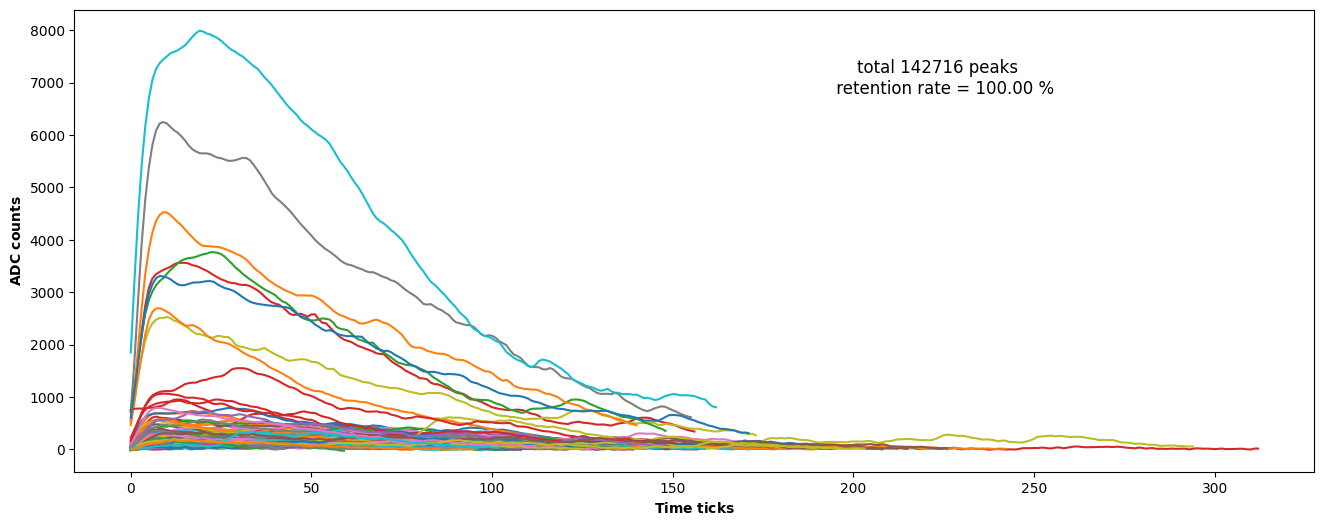

In [7]:
data_folder = '/Users/emiliebertholet/cernbox/coldbox_data'
# peak_folder = 'data_tests'
#

filename = f'{data_folder}/adc_data_run_25036_ch_40_all.npy' # neutrons
data = np.load(filename, allow_pickle=True).astype(np.int16)
data = np.apply_along_axis(substract_peds, axis=1, arr=data)

# peak_selection = []

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
count, sel = 0, 0

nTirggerRecords = 5 #len(res['peak_heights'])
for trigger_idx in range(0, nTirggerRecords):
    trigger_record = res['properties'][trigger_idx]
    for i in np.arange(0, len(trigger_record['left_ips']), 1):
        count+=1
        # if (trigger_record['plateau_sizes'][i]=1) and (trigger_record['widths'][i]>100):
        sel+=1
        l = int(np.ceil(trigger_record['left_ips'][i]))
        r = int(np.ceil(trigger_record['right_ips'][i]))
        ax.plot(data[trigger_idx][l:r].transpose())
        # peak_selection.append(data[trigger_idx][l:r])
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
u = res['flat_peak_indices']
ax.set_title(f"total {len(u)} peaks  \n retention rate = {sel*100/count:.2f} %", y=0.8, x = 0.7);
# print(len(peak_selection))
# peak_selection = np.array(peak_selection)

In [10]:

def save_file(intput_file, output_file, wlen, prominence=200, cut=None):
        raw_data = np.load(intput_file, allow_pickle=True).astype(np.int16)
        # data = np.apply_along_axis(substract_peds, axis=1, arr=data)
        data, pedestals = substract_pedestals(raw_data)
        if cut is not None:
             data = data[:, cut[0]:cut[1]]
        print(intput_file, data.shape)
        results_dict = find_peaks_2d(data, height=None, distance=100, 
                                           prominence=prominence, rel_height=0.9, wlen=wlen,  
                                           plateau_size=0, width=0 )
        results_dict["pedestals"] = pedestals 
        print('saving disabled')
        return results_dict



folder_base = '/Users/emiliebertholet/cernbox/coldbox_data'
res =  save_file(intput_file=f'{folder_base}/adc_data_run_25036_ch_40_all.npy', # neutrons
        output_file='data_tests/peaks_neutrons_wlen500.pkl', 
        wlen=500)
res.keys()



/Users/emiliebertholet/cernbox/coldbox_data/adc_data_run_25036_ch_40_all.npy (16600, 65536)


/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_6981/100465620.py:22: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


saving disabled


dict_keys(['row_peak_indices', 'peak_heights', 'properties', 'waveforms', 'flat_peak_indices', 'pedestals'])

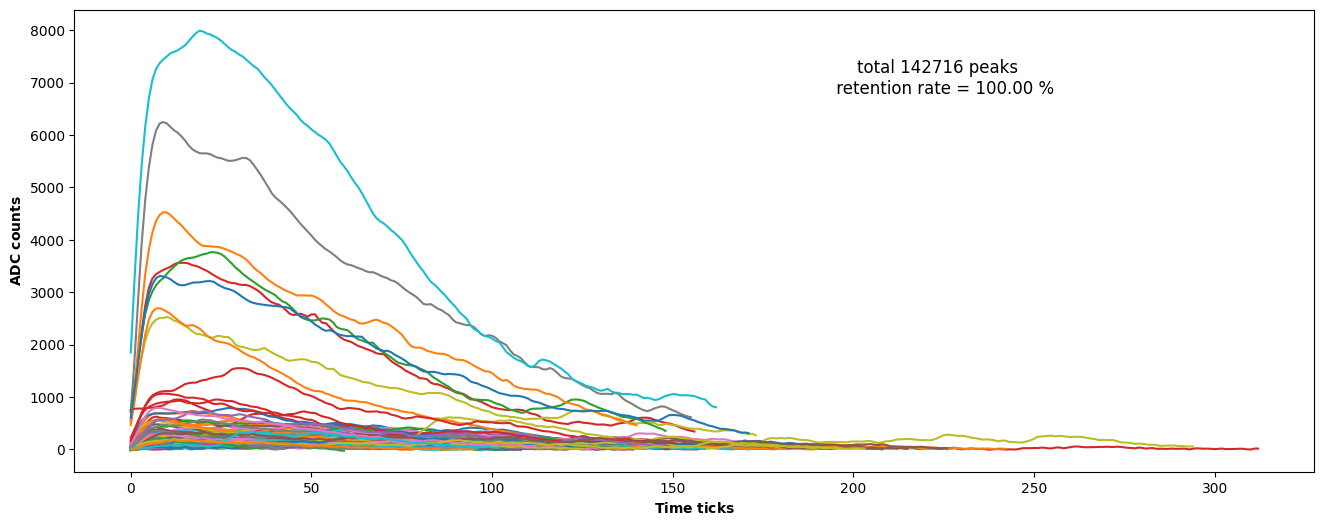

In [11]:
data_folder = '/Users/emiliebertholet/cernbox/coldbox_data'

filename = f'{data_folder}/adc_data_run_25036_ch_40_all.npy' # neutrons
data = np.load(filename, allow_pickle=True).astype(np.int16)
data = np.apply_along_axis(substract_peds, axis=1, arr=data)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
count, sel = 0, 0

nTirggerRecords = 5 #len(res['peak_heights'])
for trigger_idx in range(0, nTirggerRecords):
    trigger_record = res['properties'][trigger_idx]
    for i in np.arange(0, len(trigger_record['left_ips']), 1):
        count+=1
        sel+=1
        l = int(np.ceil(trigger_record['left_ips'][i]))
        r = int(np.ceil(trigger_record['right_ips'][i]))
        ax.plot(data[trigger_idx][l:r].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
u = res['flat_peak_indices']
ax.set_title(f"total {len(u)} peaks  \n retention rate = {sel*100/count:.2f} %", y=0.8, x = 0.7);
# print(len(peak_selection))
# peak_selection = np.array(peak_selection)

In [ ]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

def flatten_property(peaks, property):
    flat = []
    for i in range(0, len(peaks['properties'])):
        flat.extend(peaks['properties'][i][property])
    return np.array(flat)

data_folder = '/Users/emiliebertholet/cernbox/coldbox_data'
peak_folder = 'data_tests'

filename = f'{data_folder}/adc_data_run_25036_ch_40_all.npy' # neutrons
data = np.load(filename, allow_pickle=True).astype(np.int16)
data = np.apply_along_axis(substract_peds, axis=1, arr=data)

with open(f'{peak_folder}/peaks_neutrons_wlen500.pkl', 'rb') as file:
    peak_dict = pickle.load(file)

print(filename)
print(data.shape)
print('peaks_neutrons_wlen500', len(peak_dict['flat_peak_indices']))
print(peak_dict.keys())

/Users/emiliebertholet/cernbox/coldbox_data/adc_data_run_25036_ch_40_all.npy
(16600, 65536)
peaks_neutrons_wlen500 142716
dict_keys(['mask', 'row_peak_indices', 'peak_heights', 'properties', 'flat_peak_indices'])


In [7]:
peak_dict.keys()

dict_keys(['mask', 'row_peak_indices', 'peak_heights', 'properties', 'flat_peak_indices'])

In [33]:
heights = peak_dict['peak_heights']
len(heights)

16600

110479


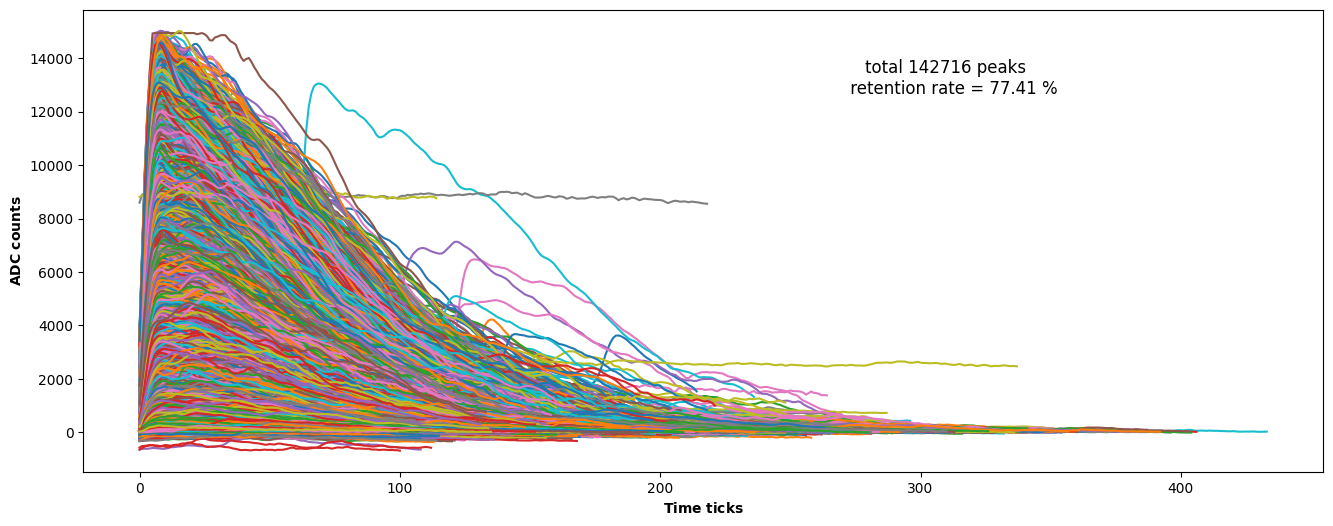

In [34]:
peak_selection = []

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
count, sel = 0, 0

nTirggerRecords = len(peak_dict['peak_heights'])
for trigger_idx in range(0, nTirggerRecords):
    trigger_record = peak_dict['properties'][trigger_idx]
    for i in np.arange(0, len(trigger_record['left_ips']), 1):
        count+=1
        if (trigger_record['plateau_sizes'][i]==1) and (trigger_record['widths'][i]>100):
            sel+=1
            l = int(np.ceil(trigger_record['left_ips'][i]))
            r = int(np.ceil(trigger_record['right_ips'][i]))
            ax.plot(data[trigger_idx][l:r].transpose())
            peak_selection.append(data[trigger_idx][l:r])
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
u = peak_dict['flat_peak_indices']
ax.set_title(f"total {len(u)} peaks  \n retention rate = {sel*100/count:.2f} %", y=0.8, x = 0.7);
print(len(peak_selection))
# peak_selection = np.array(peak_selection)


In [ ]:
# with open('PNS_waveforms.pkl', 'wb') as file:
#     pickle.dump(peak_selection, file)

In [36]:
with open(f'PNS_waveforms.pkl', 'rb') as file:
    wfs = pickle.load(file)

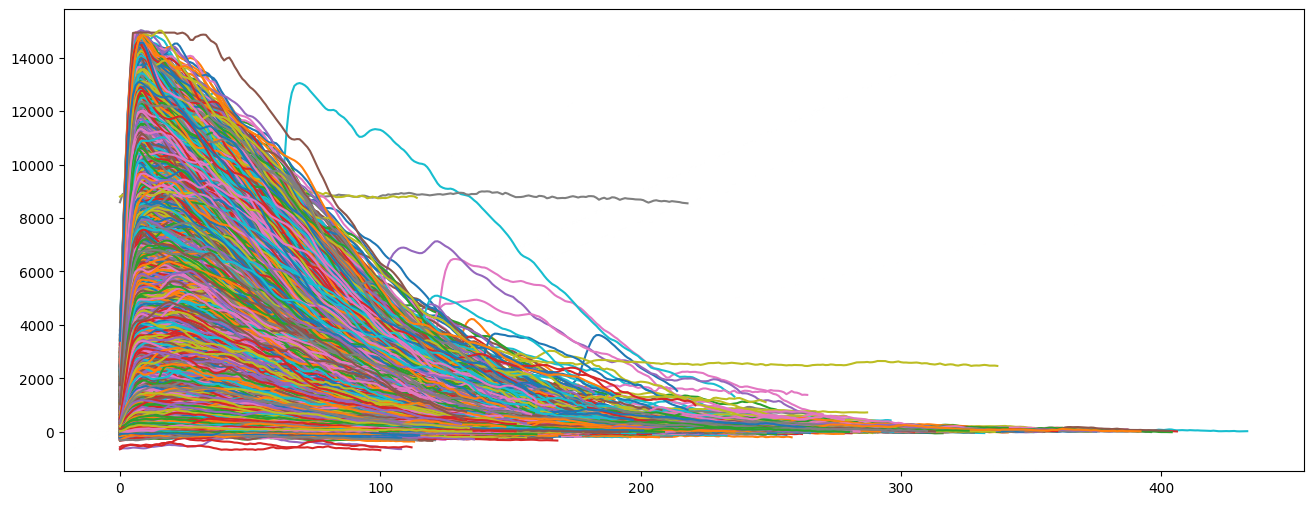

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for wf in wfs:
    ax.plot(wf.transpose())

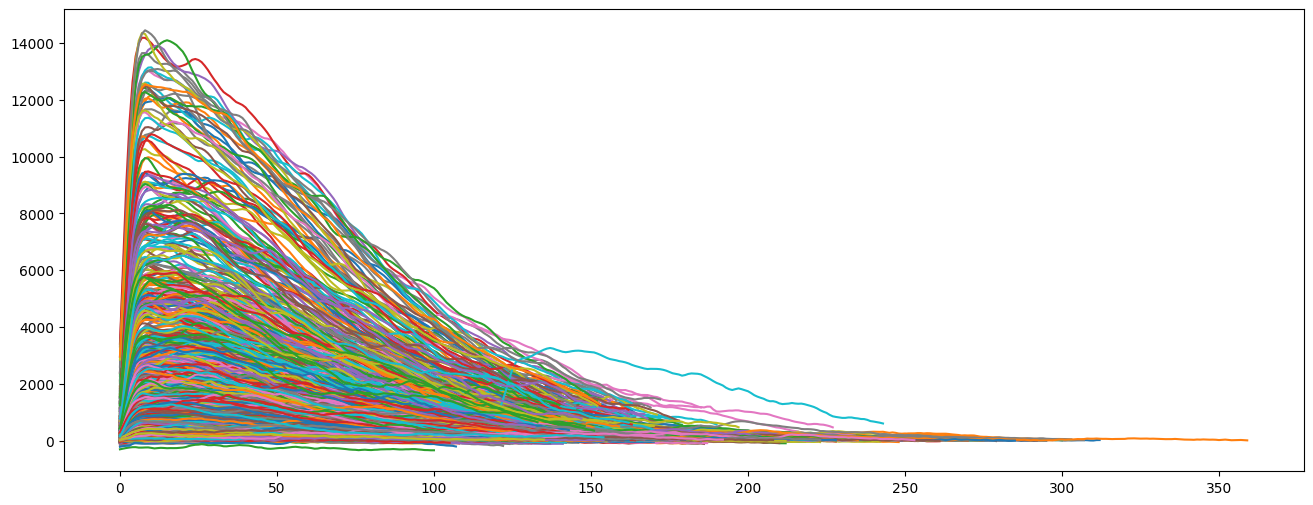

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for wf in wfs[:5000]:
    ax.plot(wf.transpose())